In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\ayats\Documents\ici`


In [4]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using TimeZones
import Arrow: Arrow

filename = "data.arrow"
if isfile(filename)
    df = DataFrame(Arrow.Table(filename))
else
    fmt1 = DateFormat("yyyy-mm-dd HH:MM:SS.ssssssz");
    fmt2 = DateFormat("yyyy-mm-dd HH:MM:SSz");

    df = CSV.read(
        "irradiance_interval_8_to_19.csv",
        DataFrame;
        # limit=5,
        select=[:table, :_time, :_value],
        types=Dict(:_time => String, :table => UInt64, :_value => Float64),
    )

    @chain df begin
        @transform!(@byrow :time =  if  length(:_time) == 25 ; ZonedDateTime(:_time, fmt2); else ZonedDateTime(:_time, fmt1); end)
        @select!(:time, :table, :value = :_value)
    end

    Arrow.write(filename, df)
end
display(df)
println(varinfo(r"^df$"))

4477495×3 DataFrame
     Row │ time                           table   value   
         │ ZonedDat…                      UInt64  Float64 
─────────┼────────────────────────────────────────────────
       1 │ 2022-02-11T08:48:00.050+00:00       0    238.0
       2 │ 2022-02-11T08:48:00.100+00:00       0    238.0
       3 │ 2022-02-11T08:48:00.150+00:00       0    238.0
       4 │ 2022-02-11T08:48:00.200+00:00       0    238.0
       5 │ 2022-02-11T08:48:00.250+00:00       0    238.0
       6 │ 2022-02-11T08:48:00.300+00:00       0    238.0
       7 │ 2022-02-11T08:48:00.350+00:00       0    238.0
       8 │ 2022-02-11T08:48:00.400+00:00       0    238.0
    ⋮    │               ⋮                  ⋮        ⋮
 4477489 │ 2022-02-11T12:42:07.984+00:00      15    777.0
 4477490 │ 2022-02-11T12:42:08.034+00:00      15    776.0
 4477491 │ 2022-02-11T12:42:08.084+00:00      15    777.0
 4477492 │ 2022-02-11T12:42:08.134+00:00      15    777.0
 4477493 │ 2022-02-11T12:42:08.184+00:00      15    777.0
 4477494 │ 2022-02-11T12:42:08.234+00:00      15    777.0
 4477495 │ 2022-02-11T12:42:08.284+00:00      15    777.0
                                      4477480 rows omitted

| name |        size | summary             |
|:---- | -----------:|:------------------- |
| df   | 204.966 MiB | 4477495×3 DataFrame |



233445×3 DataFrame
    Row │ table   time                           value   
        │ UInt64  ZonedDat…                      Float64 
────────┼────────────────────────────────────────────────
      1 │      0  2022-02-11T08:48:05.250+00:00    241.0
      2 │      0  2022-02-11T08:48:05.300+00:00    239.0
      3 │      0  2022-02-11T08:48:05.500+00:00    257.0
      4 │      0  2022-02-11T08:48:05.550+00:00    240.0
      5 │      0  2022-02-11T08:48:05.600+00:00    257.0
      6 │      0  2022-02-11T08:48:05.650+00:00    245.0
      7 │      0  2022-02-11T08:48:05.700+00:00    257.0
      8 │      0  2022-02-11T08:48:05.750+00:00    248.0
   ⋮    │   ⋮                   ⋮                   ⋮
 233439 │     15  2022-02-11T12:41:37.084+00:00    779.0
 233440 │     15  2022-02-11T12:42:00.184+00:00    779.0
 233441 │     15  2022-02-11T12:42:00.534+00:00    780.0
 233442 │     15  2022-02-11T12:42:00.584+00:00    778.0
 233443 │     15  2022-02-11T12:42:00.734+00:00    777.0
 233444 │     15  2022-02-11T12:42:01.034+00:00    778.0
 233445 │     15  2022-02-11T12:42:03.234+00:00    776.0
                                      233430 rows omitted

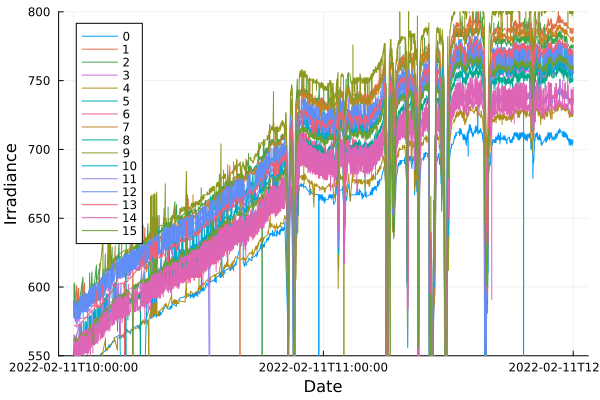

In [33]:
using StatsPlots
import Statistics as Statistics
import ShiftedArrays: lag

df₂ = df |> (x -> @chain x begin
    groupby(:table)
    @combine @astable begin
        :time = :time
        :value = :value
        value_lag = lag(:value)
        :diff = :value - value_lag
    end
    @rtransform(:diff = abs(:diff))
    @subset(:diff .>= 2.0)
    @select(:table, :time, :value)
end) |> dropmissing

display(df₂)

(@chain df₂ begin
    @subset(:time .>= ZonedDateTime(2022, 2, 11, 10, tz"UTC-0"))
    @subset(:time .<= ZonedDateTime(2022, 2, 11, 12, tz"UTC-0"))
end) |> (x -> @df x plot(:time, :value, group=:table))

xlabel!("Date")
ylabel!("Irradiance")
ylims!((550, 800))